# LINEAR REGRESSION

## Strategy & Finance: RoE model

## Part 1: Data preparation

We are going to generate a linear regression model that explains the RoE (Return on Equity) of commercial delegations in a particular company. First we are going to upload the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

In [2]:
import requests
excel_url = 'https://docs.google.com/spreadsheets/d/1qkiAsen7GWXAucdn4fi4a219YC3HB9yomai5wq6MHvQ/export?format=xlsx'
response = requests.get(excel_url)
response.raise_for_status()  # Ensure the request was successful
with open('sheet.xlsx', 'wb') as file:
    file.write(response.content)
df = pd.read_excel('sheet.xlsx')

Now let's look at the data we have loaded (first 10 rows)

In [3]:
df.head(n=10)

,RoE,More_10Y,Size,Region
0,92.460171,1,22,National
1,-6.849102,0,42,National
2,66.042092,0,33,North_America
3,70.198346,1,32,National
4,50.550568,1,11,North_America
5,19.573432,0,19,National
6,-40.000000,0,6,National
7,29.687851,1,6,National
8,56.841548,1,14,National
9,46.542791,1,13,National


More_10Y: 1 when the delegation has been in existence for more than 10 years, 0 otherwise

Size: # of employees

Region: Region where the commercial delegation is situated

We will now summarize its contents: what variables it contains and what type of variable each variable is

In [4]:
df.describe()

,RoE,More_10Y,Size
count,1014.000000,1014.000000,1014.000000
mean,44.572765,0.500986,22.442801
std,26.134470,0.500246,12.364096
min,-40.000000,0.000000,4.000000
25%,25.915480,0.000000,14.000000
50%,44.315435,1.000000,20.000000
75%,63.134602,1.000000,27.750000
max,119.466744,1.000000,99.000000


In [5]:
df.dtypes

,0
RoE,float64
More_10Y,int64
Size,int64
Region,object


The variable "Region" is categorical, so we are going to transform it into this type of data.

In [6]:
df['Region'] = df['Region'].astype('category')
df.dtypes

,0
RoE,float64
More_10Y,int64
Size,int64
Region,category


#### We filter those regions of interest (important *)

In [7]:
regions = ['National', 'North_America', 'EU', 'RoW']
rows_sel = df.Region.isin(regions)
df = df.loc[rows_sel]

We transform the categorical variable (Region) into dichotomous variables in order to incorporate it into the regression model.

In [8]:
df_Region = pd.get_dummies(df["Region"])

df = pd.concat((df, df_Region), axis=1)

df.head(n=10)

,RoE,More_10Y,Size,Region,EU,National,North_America,RoW
0,92.460171,1,22,National,False,True,False,False
1,-6.849102,0,42,National,False,True,False,False
2,66.042092,0,33,North_America,False,False,True,False
3,70.198346,1,32,National,False,True,False,False
4,50.550568,1,11,North_America,False,False,True,False
5,19.573432,0,19,National,False,True,False,False
6,-40.000000,0,6,National,False,True,False,False
7,29.687851,1,6,National,False,True,False,False
8,56.841548,1,14,National,False,True,False,False
9,46.542791,1,13,National,False,True,False,False


## Part 2: Basic exploratory analysis of the data

Let's analyze "RoE"

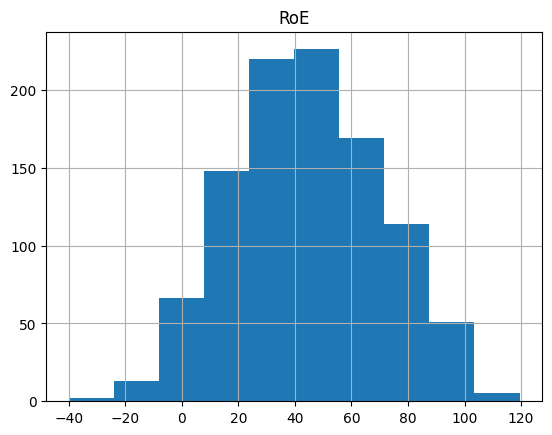

In [9]:
df.hist(column="RoE");

Nothing relevant. Now Let's analyze "Size"

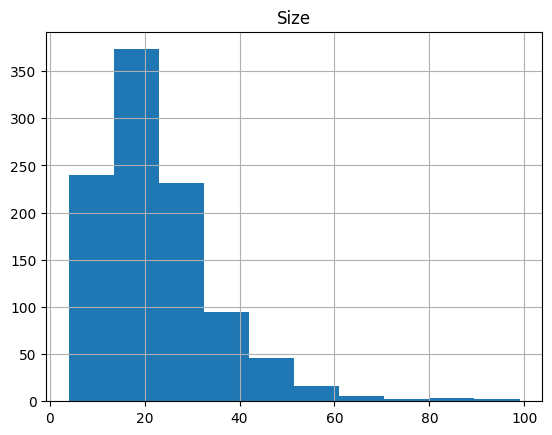

In [10]:
df.hist(column="Size");

We can see a considerable positive skewness. Probably to use logarithms is a good idea. Let's try it

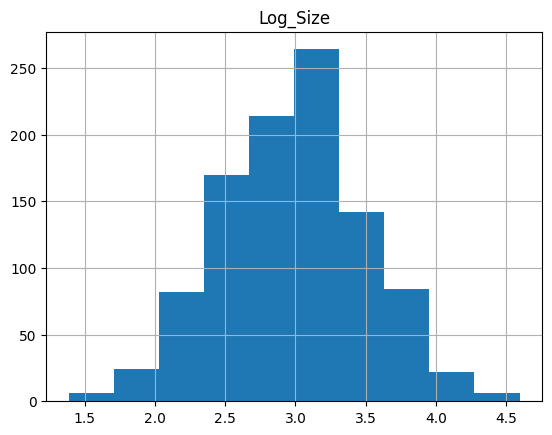

In [11]:
df['Log_Size'] = np.log(df['Size'])
df.hist(column="Log_Size");

Much better. So, we will use the Log_Size as independent variable

In the case of discrete numerical variables and categorical variables, it is appropriate to use a barplot or a pie chart.
That is the case for "Region" (categorical nominal variable)

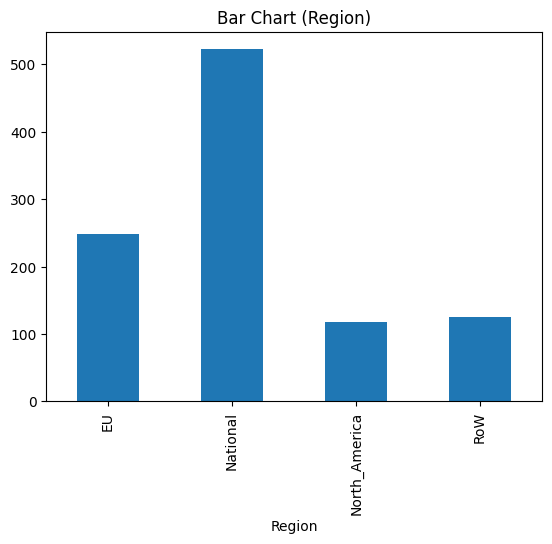

In [12]:
Table_Region = pd.crosstab(index=df['Region'], columns='count')
Table_Region.plot.bar(subplots=True,legend=False)
plt.gca().set(title='Bar Chart (Region)', ylabel='');

The same for "More_10Y" (categorical dichotomous variable)

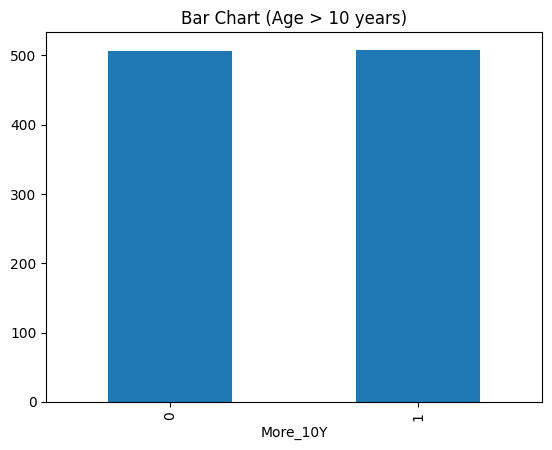

In [13]:
Table_Age = pd.crosstab(index=df['More_10Y'], columns='count')
Table_Age.plot.bar(subplots=True,legend=False)
plt.gca().set(title='Bar Chart (Age > 10 years)', ylabel='');

## Part 3: Simple Linear Regression

Now, lets fit the model:  $y \sim \beta_0 + \beta_1 \cdot \text{Log_Size} + \epsilon$

In [14]:
y = df['RoE']
x = df[['Log_Size']]

# Add constant (beta 0) to predictor variables
x = sm.add_constant(x) #  we need to add the intercept term explicitly

#fit linear regression model
model_1 = sm.OLS(y, x)
regr_results_model_1 = model_1.fit()

print(regr_results_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    RoE   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     31.72
Date:                Sun, 04 Aug 2024   Prob (F-statistic):           2.30e-08
Time:                        11:49:39   Log-Likelihood:                -4731.6
No. Observations:                1014   AIC:                             9467.
Df Residuals:                    1012   BIC:                             9477.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.0978      4.770      3.794      0.0

However, previous studies (literature review) point to a possible interaction between size and age of the trade delegation. Let's verify it

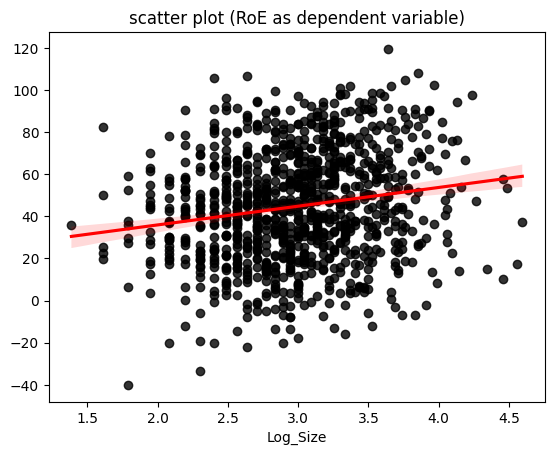

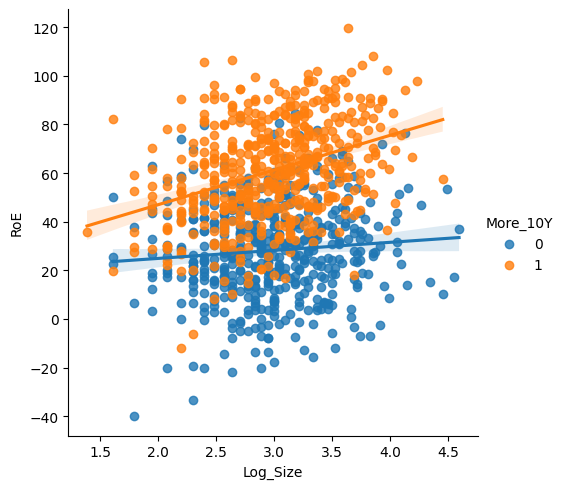

In [15]:
sns.regplot(x='Log_Size', y='RoE', data=df,
                 scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.gca().set(title='scatter plot (RoE as dependent variable)', ylabel='');
sns.lmplot(x="Log_Size", y="RoE", hue="More_10Y", data=df);

Indeed, there seems to be an interaction between the two variables. We should include it in the final model

## Part 4: Multiple Linear Regression

Now, lets fit the final model:
$y \sim \beta_0 + \beta_1 \cdot \text{More_10Y} + \beta_2 \cdot \text{Log_Size}
+ \beta_3 \cdot \text{National} + \beta_4 \cdot \text{EU} + \beta_5 \cdot \text{North_America} + \beta_6 \cdot \text{More_10Y*Log_Size}
+ \epsilon$

Warning!!!

As we are going to include an interaction, we must center numerical variables to avoid multicolinearity problems

In [16]:
Log_Size_centered = (df['Log_Size']) - np.mean(df['Log_Size'])
df["Log_Size_centered"] = Log_Size_centered

RoE_centered = (df['RoE']) - np.mean(df['RoE'])
df["RoE_centered"] = RoE_centered

Interaction_Log_Size_centered_More_10Y = (df['Log_Size_centered'])*(df['More_10Y'])
df["Interaction_Log_Size_centered_More_10Y"] = Interaction_Log_Size_centered_More_10Y

df.head(n=10)

,RoE,More_10Y,Size,Region,EU,National,North_America,RoW,Log_Size,Log_Size_centered,RoE_centered,Interaction_Log_Size_centered_More_10Y
0,92.460171,1,22,National,False,True,False,False,3.091042,0.111940,47.887406,0.111940
1,-6.849102,0,42,National,False,True,False,False,3.737670,0.758567,-51.421867,0.000000
2,66.042092,0,33,North_America,False,False,True,False,3.496508,0.517405,21.469327,0.000000
3,70.198346,1,32,National,False,True,False,False,3.465736,0.486633,25.625581,0.486633
4,50.550568,1,11,North_America,False,False,True,False,2.397895,-0.581208,5.977803,-0.581208
5,19.573432,0,19,National,False,True,False,False,2.944439,-0.034664,-24.999333,-0.000000
6,-40.000000,0,6,National,False,True,False,False,1.791759,-1.187343,-84.572765,-0.000000
7,29.687851,1,6,National,False,True,False,False,1.791759,-1.187343,-14.884914,-1.187343
8,56.841548,1,14,National,False,True,False,False,2.639057,-0.340046,12.268783,-0.340046
9,46.542791,1,13,National,False,True,False,False,2.564949,-0.414154,1.970027,-0.414154


Now data are prepared. Let's fit the model

In [17]:
y = df['RoE_centered']
x = df[['More_10Y','Log_Size_centered','National','EU','North_America',
        'Interaction_Log_Size_centered_More_10Y']]
for column in x.select_dtypes(include='bool'):
    x[column] = x[column].astype(int)
x = sm.add_constant(x) #  we need to add the intercept term explicitly

#fit linear regression model
model_2 = sm.OLS(y, x)
regr_results_model_2 = model_2.fit()

print(regr_results_model_2.summary())


                            OLS Regression Results                            
Dep. Variable:           RoE_centered   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     168.0
Date:                Sun, 04 Aug 2024   Prob (F-statistic):          6.75e-148
Time:                        11:49:41   Log-Likelihood:                -4395.6
No. Observations:                1014   AIC:                             8805.
Df Residuals:                    1007   BIC:                             8840.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

<ipython-input-17-44dbb5c23ead>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[column] = x[column].astype(int)
<ipython-input-17-44dbb5c23ead>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[column] = x[column].astype(int)
<ipython-input-17-44dbb5c23ead>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]

print(vif_data)

                                  feature       VIF
0                                   const  9.135694
1                                More_10Y  1.001500
2                       Log_Size_centered  1.980357
3                                National  2.514785
4                                      EU  2.259679
5                           North_America  1.718863
6  Interaction_Log_Size_centered_More_10Y  1.979686


No multicolinearity problems: all VIFs are below 5 (except "constant", that is not relevant for the analysis)

Let's check heterokedasticity (White test)

In [19]:
from statsmodels.stats.diagnostic import het_white
white_test = het_white(regr_results_model_2.resid,  regr_results_model_2.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'Test Statistic': 12.289802142744104, 'Test Statistic p-value': 0.7822797708648385, 'F-Statistic': 0.718808514875329, 'F-Test p-value': 0.7856025558268565}


We don't have a problem of heteroscedasticity (p-value > 0.05). So, we can continue
Let's check the normality of the residuals

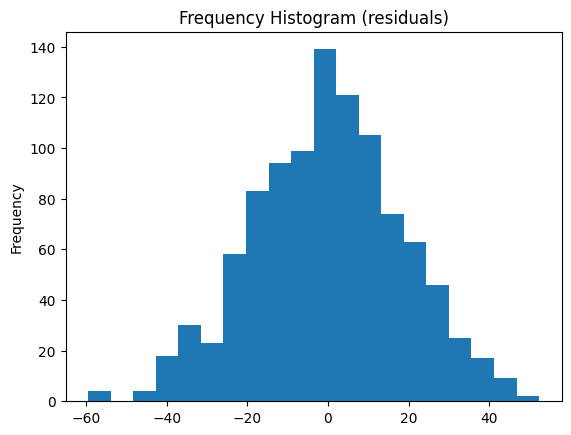

In [20]:
res = regr_results_model_2.resid # residuals
plt.hist(res, bins=20)
plt.gca().set(title='Frequency Histogram (residuals)', ylabel='Frequency');

ShapiroResult(statistic=0.9982118778547965, pvalue=0.3709747923340958)

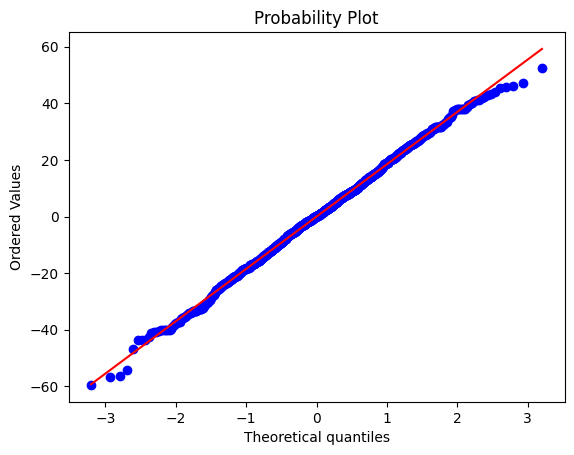

In [21]:
stats.probplot(res, dist="norm", plot=plt)
stats.shapiro(res)

All seems correct: residuals are normal